# Определение возраста покупателей

__О проекте__

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

__Главная цель проекта:__ построить модель, которая по фотографии определит приблизительный возраст человека. 

__Описание данных для исследования:__ набор фотографий людей с указанием возраста.

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке `/datasets/faces/` (одна папка со всеми изображениями (`/final_files`) и CSV-файл `age_labels.csv` с двумя колонками: file_name и real_age). 

__Качество требуемой модели__: метрика МАЕ на тестовой выборке не больше 8.

## Исследовательский анализ данных

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# константы
SEED = 12345

In [ ]:
data_labels = pd.read_csv('/datasets/faces/age_labels.csv')

In [3]:
data_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
data_labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
data_labels.duplicated(subset=['file_name']).sum()

0

In [6]:
data_labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


В файле `age_labels.csv` содержится информация о 7591 файле, содержащем изображения, каждому изображению сопоставлен возраст - целое число от 1 до 100. Файлы не упорядочены по возрасту, каждый файл упоминается только один раз. Среднее и медианное значения близки - 31 и 29 соответственно. Межквартильный размах - от 20 до 41.

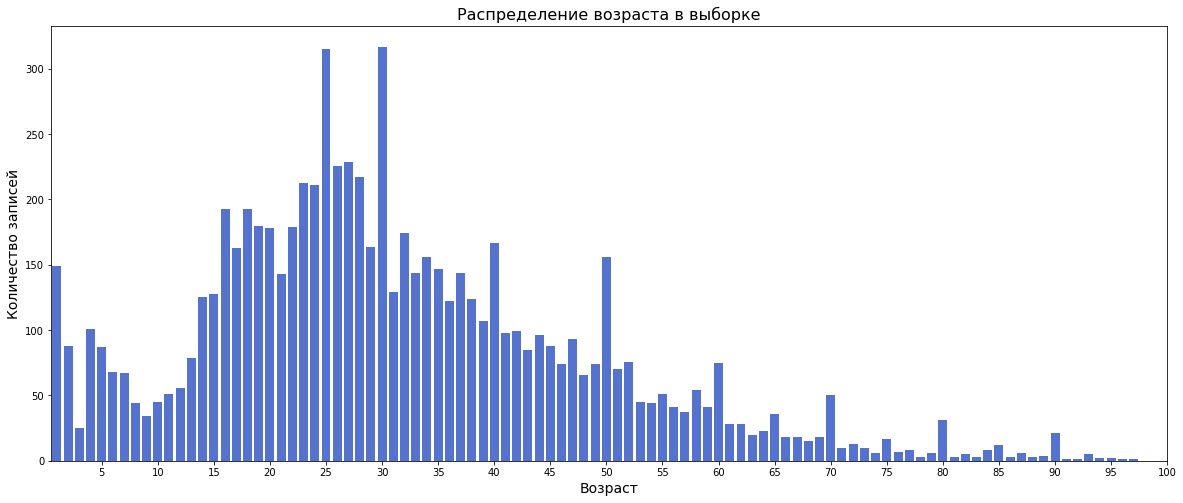

In [7]:
plt.figure(figsize=(20, 8))
ax = sns.countplot(x=data_labels['real_age'], color='royalblue')
ax.set_title('Распределение возраста в выборке', fontsize=16)
ax.set_xlabel('Возраст', fontsize=14)
ax.set_ylabel('Количество записей', fontsize=14)
ax.grid(False)

ax.set_xticks(range(4, 100, 5))  
ax.set_xticklabels(range(5, 101, 5), fontsize=10)  

plt.show()

Распределение неоднородное, ассиметричное, фотографий людей пожилого возраста намного меньше, чем фото молодых людей. Пики распределения - 25 и 30 лет. Также видим, что выделяются  "круглые значения" возраста (40, 50, 60, 70, 80, 90).

Посмотрим на некоторые изображения из наших данных.

Found 7591 validated image filenames.


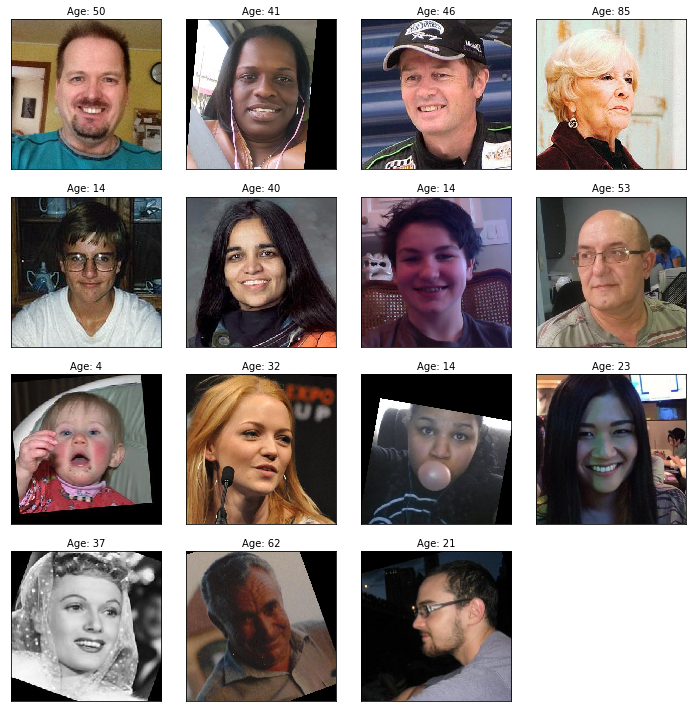

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
    dataframe=data_labels,              
    directory='/datasets/faces/final_files',         
    x_col="file_name",      
    y_col="real_age", 
    color_mode='rgb',  
    batch_size=32,      
    class_mode='raw', 
    target_size=(150, 150), 
    seed=SEED,  
    validate_filenames=True 
)

features, target = next(datagen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f"Age: {int(target[i])}", fontsize=10, pad=5, color='black')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

__Промежуточный вывод:__

- у нас имеется 7591 изображение для проведения исследования;
- значения целевого признака находятся в промежутке от 1 до 100, что соответсвует возможному реальному возрасту; среднее и медианное значения - 31 и 29 соответственно, межквартильный размах - от 20 до 41, моды - 25  и 30;
- из-за неоднородности выборки (преобладание фото молодых людей и низкое количество экземпляров фото пожилых людей), модель может хуже справляться с предсказанием возраста пожилых людей.

## Обучение модели

За основу возьмем ResNet50 без топ-слоев. Решаем задачу регрессии, добавим GlobalAveragePooling2D и Dense с 1 нейроном. В качестве функции активации используем ReLU, т.к. предсказываем возраст и отрицательные значения нам не подходят.

```python

import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_train(path):
    """
    Загружает и подготавливает тренировочные данные с аугментацией.
    
    Parameters:
    -----------
    path - Путь к директории с данными (должна содержать 'age_labels.csv' и 'final_files/')
    
    Returns:
    --------
    train_datagen_flow - Генератор тренировочных данных с аугментацией
    """    
    data_labels = pd.read_csv(path + 'age_labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1./255, 
                                 horizontal_flip=True,
                                 vertical_flip=True
                                 )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=data_labels,               
        directory=path + 'final_files/',         
        x_col="file_name",       
        y_col="real_age",          
        target_size=(150, 150), 
        batch_size=16,          
        class_mode='raw', 
        subset='training',
        seed=SEED,           
        validate_filenames=True 
    )

    return train_datagen_flow

def load_test(path):
    """
    Загружает тестовые данные.
    
    Parameters:
    -----------
    path - Путь к директории с данными (должна содержать 'age_labels.csv' и 'final_files/')
    
    Returns:
    --------
    test_datagen_flow - Генератор тестовых данных
    """    
    data_labels = pd.read_csv(path + 'age_labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=data_labels,              
        directory=path + 'final_files/',         
        x_col="file_name",      
        y_col="real_age",          
        target_size=(150, 150), 
        batch_size=16,          
        class_mode='raw', 
        subset='validation',
        seed=SEED,            
        validate_filenames=True
    )    
    return test_datagen_flow


def create_model(input_shape):
    """
    Создает модель для регрессии на основе ResNet50.
    
    Parameters:
    -----------
    input_shape - Размер входных изображений в формате
    
    Returns:
    --------
    model - Скомпилированная модель с архитектурой:
        1. ResNet50 (без top-слоев)
        2. GlobalAveragePooling2D
        3. Dense слой с 1 нейроном (регрессия)    
    """
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(learning_rate=1e-4) 
    model.compile(optimizer=optimizer, loss='mae',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=6,
               steps_per_epoch=None, validation_steps=None):
    """
    Обучает модель на предоставленных данных.
    
    Parameters:
    -----------
    model - Модель для обучения
    train_data - Генератор тренировочных данных
    test_data - Генератор валидационных данных
    batch_size - Размер батча
    epochs - Количество эпох обучения
    steps_per_epoch - Шагов на эпоху
    validation_steps - Шагов валидации 
    
    Returns:
    --------
    model - Обученная модель
    """
    model.fit(train_data,
              validation_data=test_data, batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2
              )
    return model

```

Результат вывода модели:

```

Train for 356 steps, validate for 119 steps
Epoch 1/6
2025-04-17 07:52:43.720682: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-04-17 07:52:44.371001: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 86s - loss: 11.6220 - mae: 11.6231 - val_loss: 25.9888 - val_mae: 25.9896
Epoch 2/6
356/356 - 53s - loss: 8.5999 - mae: 8.6004 - val_loss: 10.0992 - val_mae: 10.0978
Epoch 3/6
356/356 - 53s - loss: 7.9337 - mae: 7.9337 - val_loss: 8.6335 - val_mae: 8.6294
Epoch 4/6
356/356 - 48s - loss: 7.3269 - mae: 7.3277 - val_loss: 7.6327 - val_mae: 7.6320
Epoch 5/6
356/356 - 43s - loss: 6.8309 - mae: 6.8308 - val_loss: 7.4891 - val_mae: 7.4863
Epoch 6/6
356/356 - 42s - loss: 6.4842 - mae: 6.4850 - val_loss: 7.2056 - val_mae: 7.2076
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 7.2056 - mae: 7.2076
Test MAE: 7.2076
```

Модель показала значительное улучшение уже на второй эпохе, после 3 эпохи наблюдается плавное снижение ошибки. Отсутствует переобучение - разница между train и val MAE минимальна.

## Анализ обученной модели

Мы провели исследовательский анализ данных и выявили неоднородность выборки.  Обучение модели на 6 эпохах позволило достигнуть требуемого значения целевой метрики MAE: 7.2, что соответствует поставленной задаче.

Данная модель может использоваться для анализа покупок и предложения товаров, однако ошибка довольно большая, чтобы использовать ее при контроле продажи алкоголя несовершеннолетним.

Преложения по улучшению: расширить данные для иcследования, дополнить их изображениями лиц пожилого возраста, а также изображениями лиц возраста, не кратного 10.
Касательно задачи выявления несовершеннолетних, рассмотреть возможность сканирования паспорта и сопоставления фото из него с лицом покупателя, т.к. люди могут не выглядеть на свой возраст (генетические факторы, болезни и прочее).